In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np
import requests
import os

In [2]:
# Download the dataset
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text_path = "tiny_shakespeare.txt"

if not os.path.exists(text_path):
    with open(text_path, 'w') as f:
        f.write(requests.get(url).text)

# Read and encode characters
with open(text_path, 'r') as f:
    text = f.read()
    
text = text[:50_000]

chars = sorted(list(set(text)))
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

vocab_size = len(chars)
encoded_text = [stoi[c] for c in text]

print(f"Dataset length: {len(encoded_text)} characters")
print(f"Vocab size: {vocab_size}")

Dataset length: 50000 characters
Vocab size: 59


In [3]:
class CharDataset(Dataset):
    def __init__(self, data, seq_len):
        self.data = data
        self.seq_len = seq_len

    def __len__(self):
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_len+1], dtype=torch.long)
        return x, y

SEQ_LEN = 100
BATCH_SIZE = 1

dataset = CharDataset(encoded_text, SEQ_LEN)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [4]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embed(x)
        out, hidden = self.lstm(x, hidden)
        logits = self.fc(out)
        return logits, hidden

In [5]:
def compute_gradient_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            total_norm += (p.grad.data.norm(2)**2).item()
    return total_norm**0.5

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CharLSTM(vocab_size).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

GRAD_CLIP_NORM = 1.0
EPOCHS = 1

grad_norms = []
losses = []

for epoch in range(EPOCHS):
    hidden = None
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, hidden = model(x, hidden)

        # Detach hidden states to prevent backprop through time
        if isinstance(hidden, tuple):  # For LSTM: (h, c)
            hidden = tuple(h.detach() for h in hidden)
        else:
            hidden = hidden.detach()
    
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()

        grad_norm = compute_gradient_norm(model)
        grad_norms.append(grad_norm)

        # Gradient clipping baseline
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_NORM)

        optimizer.step()
        losses.append(loss.item())

        if i % 100 == 0:
            print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}, Grad Norm: {grad_norm:.4f}")

Epoch 1, Step 0, Loss: 4.0716, Grad Norm: 0.2897
Epoch 1, Step 100, Loss: 3.7866, Grad Norm: 0.2955
Epoch 1, Step 200, Loss: 3.1634, Grad Norm: 0.3882
Epoch 1, Step 300, Loss: 3.2506, Grad Norm: 0.4628
Epoch 1, Step 400, Loss: 3.4802, Grad Norm: 0.4004
Epoch 1, Step 500, Loss: 3.0854, Grad Norm: 0.4297
Epoch 1, Step 600, Loss: 3.3405, Grad Norm: 0.3752
Epoch 1, Step 700, Loss: 3.1108, Grad Norm: 0.4024
Epoch 1, Step 800, Loss: 2.9756, Grad Norm: 0.4587
Epoch 1, Step 900, Loss: 3.0631, Grad Norm: 0.4843
Epoch 1, Step 1000, Loss: 3.1118, Grad Norm: 0.6399
Epoch 1, Step 1100, Loss: 2.9171, Grad Norm: 0.6483
Epoch 1, Step 1200, Loss: 3.0750, Grad Norm: 0.6721
Epoch 1, Step 1300, Loss: 2.9168, Grad Norm: 0.5528
Epoch 1, Step 1400, Loss: 2.7993, Grad Norm: 0.5882
Epoch 1, Step 1500, Loss: 2.7853, Grad Norm: 0.8700
Epoch 1, Step 1600, Loss: 2.8054, Grad Norm: 0.8408
Epoch 1, Step 1700, Loss: 2.5852, Grad Norm: 1.0635
Epoch 1, Step 1800, Loss: 2.8163, Grad Norm: 0.5716
Epoch 1, Step 1900, Loss

In [7]:
baseline_model_path = "char_lstm_baseline.pt"

# Save model + vocab for reuse
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': vocab_size,
    'stoi': stoi,
    'itos': itos
}, baseline_model_path)

print(f"Baseline model saved to {baseline_model_path}")

Baseline model saved to char_lstm_baseline.pt


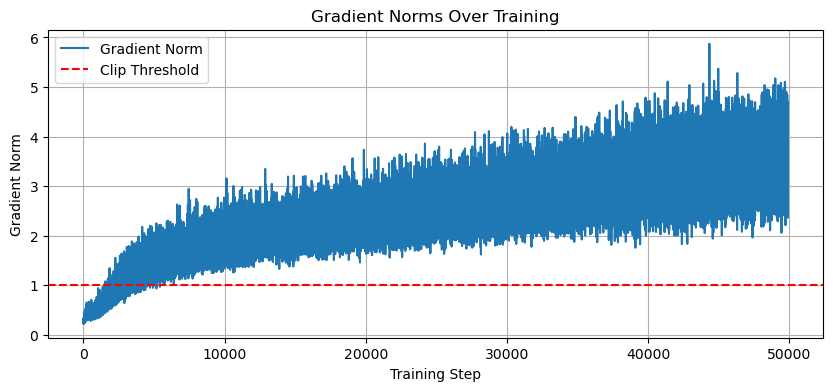

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(grad_norms, label="Gradient Norm")
plt.axhline(GRAD_CLIP_NORM, color='r', linestyle='--', label="Clip Threshold")
plt.xlabel("Training Step")
plt.ylabel("Gradient Norm")
plt.title("Gradient Norms Over Training")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
class GradientNormPredictor:
    def __init__(self, alpha=0.9):
        self.alpha = alpha
        self.ewma = None

    def update(self, value):
        if self.ewma is None:
            self.ewma = value
        else:
            self.ewma = self.alpha * self.ewma + (1 - self.alpha) * value
        return self.ewma

    def predict(self):
        return self.ewma if self.ewma is not None else 0.0

In [11]:
# Reset model and optimizer
model = CharLSTM(vocab_size).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05)
criterion = nn.CrossEntropyLoss()

predictor = GradientNormPredictor(alpha=0.9)
PRED_CLIP_THRESHOLD = 1.0
EPOCHS = 1

grad_norms_predicted = []
grad_norms_actual = []
losses_pred_clip = []

for epoch in range(EPOCHS):
    hidden = None
    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits, hidden = model(x, hidden)

        # Detach hidden state to prevent graph buildup
        if isinstance(hidden, tuple):
            hidden = tuple(h.detach() for h in hidden)
        else:
            hidden = hidden.detach()

        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        loss.backward()

        # Compute current gradient norm
        grad_norm = compute_gradient_norm(model)
        grad_norms_actual.append(grad_norm)

        # Predict next norm
        predicted_norm = predictor.update(grad_norm)
        grad_norms_predicted.append(predicted_norm)

        # Clip if predicted norm is too high
        if predicted_norm > PRED_CLIP_THRESHOLD:
            torch.nn.utils.clip_grad_norm_(model.parameters(), PRED_CLIP_THRESHOLD)

        optimizer.step()
        losses_pred_clip.append(loss.item())

        if i % 100 == 0:
            print(f"[PRED CLIP] Epoch {epoch+1}, Step {i}, Loss: {loss.item():.4f}, "
                  f"Grad: {grad_norm:.4f}, Predicted: {predicted_norm:.4f}")

[PRED CLIP] Epoch 1, Step 0, Loss: 4.0725, Grad: 0.3298, Predicted: 0.3298
[PRED CLIP] Epoch 1, Step 100, Loss: 3.7590, Grad: 0.4254, Predicted: 0.4198
[PRED CLIP] Epoch 1, Step 200, Loss: 3.2817, Grad: 0.3442, Predicted: 0.3683
[PRED CLIP] Epoch 1, Step 300, Loss: 3.3049, Grad: 0.4046, Predicted: 0.4079
[PRED CLIP] Epoch 1, Step 400, Loss: 3.3988, Grad: 0.3699, Predicted: 0.4037
[PRED CLIP] Epoch 1, Step 500, Loss: 3.3949, Grad: 0.3671, Predicted: 0.4191
[PRED CLIP] Epoch 1, Step 600, Loss: 2.9439, Grad: 0.5548, Predicted: 0.4454
[PRED CLIP] Epoch 1, Step 700, Loss: 3.2513, Grad: 0.4824, Predicted: 0.4535
[PRED CLIP] Epoch 1, Step 800, Loss: 3.0712, Grad: 0.5097, Predicted: 0.4841
[PRED CLIP] Epoch 1, Step 900, Loss: 3.4055, Grad: 0.4910, Predicted: 0.5268
[PRED CLIP] Epoch 1, Step 1000, Loss: 2.9436, Grad: 0.6814, Predicted: 0.5448
[PRED CLIP] Epoch 1, Step 1100, Loss: 2.8729, Grad: 0.5531, Predicted: 0.5786
[PRED CLIP] Epoch 1, Step 1200, Loss: 2.6410, Grad: 0.7423, Predicted: 0.586

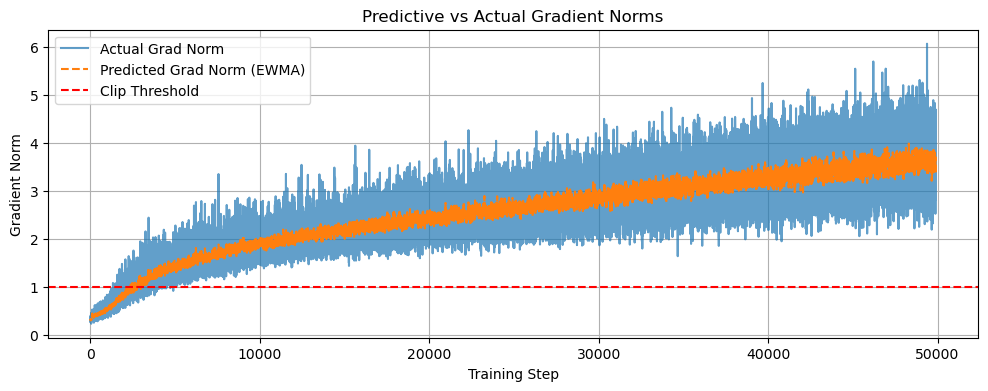

In [12]:
plt.figure(figsize=(12, 4))
plt.plot(grad_norms_actual, label="Actual Grad Norm", alpha=0.7)
plt.plot(grad_norms_predicted, label="Predicted Grad Norm (EWMA)", linestyle="--")
plt.axhline(PRED_CLIP_THRESHOLD, color='r', linestyle='--', label="Clip Threshold")
plt.xlabel("Training Step")
plt.ylabel("Gradient Norm")
plt.title("Predictive vs Actual Gradient Norms")
plt.legend()
plt.grid(True)
plt.show()

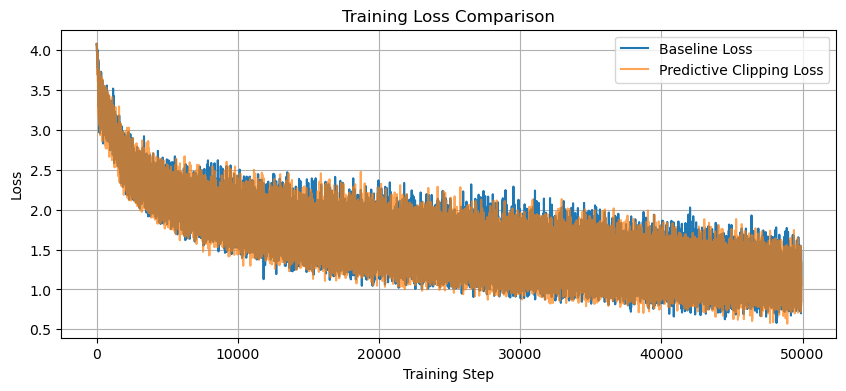

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(losses[:len(losses_pred_clip)], label="Baseline Loss")
plt.plot(losses_pred_clip, label="Predictive Clipping Loss", alpha=0.7)
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()